<a href="https://colab.research.google.com/github/niitish/mlp/blob/main/giveMeSomeCredit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Give Me Some Credit
Solution to Kaggle Competitions problem [Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit/).

### Problem Description:
The problem is to predict whether a person will be able to repay the loan considering the parameters given in the dataset. We have to predict the probability of repayment based on which bank will decide whether to grant the credit or not.

## Installing libraries

We begin by installing the required python libraries for linear algebra, loading datasets, graph plotting and model training. 

In [1]:
pip install numpy pandas scikit-learn matplotlib seaborn --quiet

In [2]:
pip install opendatasets xgboost --upgrade --quiet

     |████████████████████████████████| 173.5 MB 7.6 kB/s 


## Downloading datasets

In [ ]:
import opendatasets as od

In [ ]:
# competition url for downloading the datasets
dataset_url = 'https://www.kaggle.com/c/GiveMeSomeCredit/'

In [ ]:
# this block will require your Kaggle username and API key
od.download(dataset_url, force=True)

In [ ]:
# the downloaded datasets are stored in GiveMeSomeCredit folder,
# lets branch into it
%cd GiveMeSomeCredit

/content/GiveMeSomeCredit


## Dataset description

* _**SeriousDlqin2yrs**_: Person experienced 90 days past due delinquency or worse. This is the label which we need to predict.

* _**RevolvingUtilizationOfUnsecuredLines**_:
Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits.

* _**age**_:
Age of borrower in years.

* _**NumberOfTime30-59DaysPastDueNotWorse**_:
Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

* _**DebtRatio**_:
Monthly debt payments, alimony, living costs divided by monthy gross income.

* _**MonthlyIncome**_:
Monthly income.

* _**NumberOfOpenCreditLinesAndLoans**_:
Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards).

* _**NumberOfTimes90DaysLate**_:
Number of times borrower has been 90 days or more past due.

* _**NumberRealEstateLoansOrLines**_:
Number of mortgage and real estate loans including home equity lines of credit.

* _**NumberOfTime60-89DaysPastDueNotWorse**_:
Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

* _**NumberOfDependents**_:
Number of dependents in family excluding themselves (spouse, children etc.)

## Loading dataset

In [48]:
import pandas as pd
import numpy as np

In [49]:
# load test and train datasets
train_df = pd.read_csv('cs-training.csv', index_col=0)
test_df = pd.read_csv('cs-test.csv', index_col=0)

In [50]:
train_df.rename(columns={"SeriousDlqin2yrs":"seriousd2y",
                         "RevolvingUtilizationOfUnsecuredLines":"ruoul",
                         "NumberOfTime30-59DaysPastDueNotWorse":"t30-59late",
                         "DebtRatio":"debtratio",
                         "MonthlyIncome":"incomepm",
                         "NumberOfOpenCreditLinesAndLoans":"nocll",
                         "NumberOfTimes90DaysLate":"t90late",
                         "NumberRealEstateLoansOrLines":"nrell",
                         "NumberOfTime60-89DaysPastDueNotWorse":"t60-89late",
                         "NumberOfDependents":"dependents"}, inplace=True)

In [51]:
test_df.rename(columns={"SeriousDlqin2yrs":"seriousd2y",
                         "RevolvingUtilizationOfUnsecuredLines":"ruoul",
                         "NumberOfTime30-59DaysPastDueNotWorse":"t30-59late",
                         "DebtRatio":"debtratio",
                         "MonthlyIncome":"incomepm",
                         "NumberOfOpenCreditLinesAndLoans":"nocll",
                         "NumberOfTimes90DaysLate":"t90late",
                         "NumberRealEstateLoansOrLines":"nrell",
                         "NumberOfTime60-89DaysPastDueNotWorse":"t60-89late",
                         "NumberOfDependents":"dependents"}, inplace=True)

In [52]:
train_df.head()

,seriousd2y,ruoul,age,t30-59late,debtratio,incomepm,nocll,t90late,nrell,t60-89late,dependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [53]:
input_cols = train_df.columns.drop('seriousd2y')
target_cols = ['seriousd2y']

## Imputing missing values

In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   seriousd2y  150000 non-null  int64  
 1   ruoul       150000 non-null  float64
 2   age         150000 non-null  int64  
 3   t30-59late  150000 non-null  int64  
 4   debtratio   150000 non-null  float64
 5   incomepm    120269 non-null  float64
 6   nocll       150000 non-null  int64  
 7   t90late     150000 non-null  int64  
 8   nrell       150000 non-null  int64  
 9   t60-89late  150000 non-null  int64  
 10  dependents  146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [55]:
train_df.isnull().sum()

seriousd2y        0
ruoul             0
age               0
t30-59late        0
debtratio         0
incomepm      29731
nocll             0
t90late           0
nrell             0
t60-89late        0
dependents     3924
dtype: int64

As per above info, there are no categorical columns, so we don't need to worry about One Hot Encoding.
However, the column 'MonthlyIncome' and 'NumberOfDependents' have missing values, we need to handle those by imputing them.

In [56]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
train_df[input_cols] = imputer.fit_transform(train_df[input_cols])
test_df[input_cols] = imputer.transform(test_df[input_cols])

In [57]:
train_df.isnull().sum()

seriousd2y    0
ruoul         0
age           0
t30-59late    0
debtratio     0
incomepm      0
nocll         0
t90late       0
nrell         0
t60-89late    0
dependents    0
dtype: int64

## Feature scaling

In [58]:
train_df.describe()

,seriousd2y,ruoul,age,t30-59late,debtratio,incomepm,nocll,t90late,nrell,t60-89late,dependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.288045e+04,5.145951,4.169304,1.129771,4.155179,1.100404
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,6.600000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


We need to scale the input labels so that our model doesn't treats labels differently.
We will use MinMaxScaler to scale the values.

In [59]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()

In [60]:
train_df[input_cols].describe()

,ruoul,age,t30-59late,debtratio,incomepm,nocll,t90late,nrell,t60-89late,dependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,249.755371,14.771866,4.192781,2037.818523,1.288045e+04,5.145951,4.169304,1.129771,4.155179,1.100404
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,6.600000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [61]:
train_df[input_cols] = scalar.fit_transform(train_df[input_cols])
test_df[input_cols] = scalar.fit_transform(test_df[input_cols])

In [62]:
train_df[input_cols].describe()

,ruoul,age,t30-59late,debtratio,incomepm,nocll,t90late,nrell,t60-89late,dependents
count,1.500000e+05,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,1.192798e-04,0.479773,0.004296,1.070803e-03,0.002217,0.145737,0.002714,0.018856,0.002453,0.037861
std,4.925364e-03,0.135522,0.042783,6.181502e-03,0.004281,0.088723,0.042544,0.020922,0.042400,0.055020
min,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.890085e-07,0.376147,0.000000,5.310675e-07,0.001297,0.086207,0.000000,0.000000,0.000000,0.000000
50%,3.040560e-06,0.477064,0.000000,1.111762e-06,0.002194,0.137931,0.000000,0.018519,0.000000,0.000000
75%,1.102481e-05,0.577982,0.000000,2.633754e-06,0.002459,0.189655,0.000000,0.037037,0.000000,0.050000
max,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Choosing labels to use for training

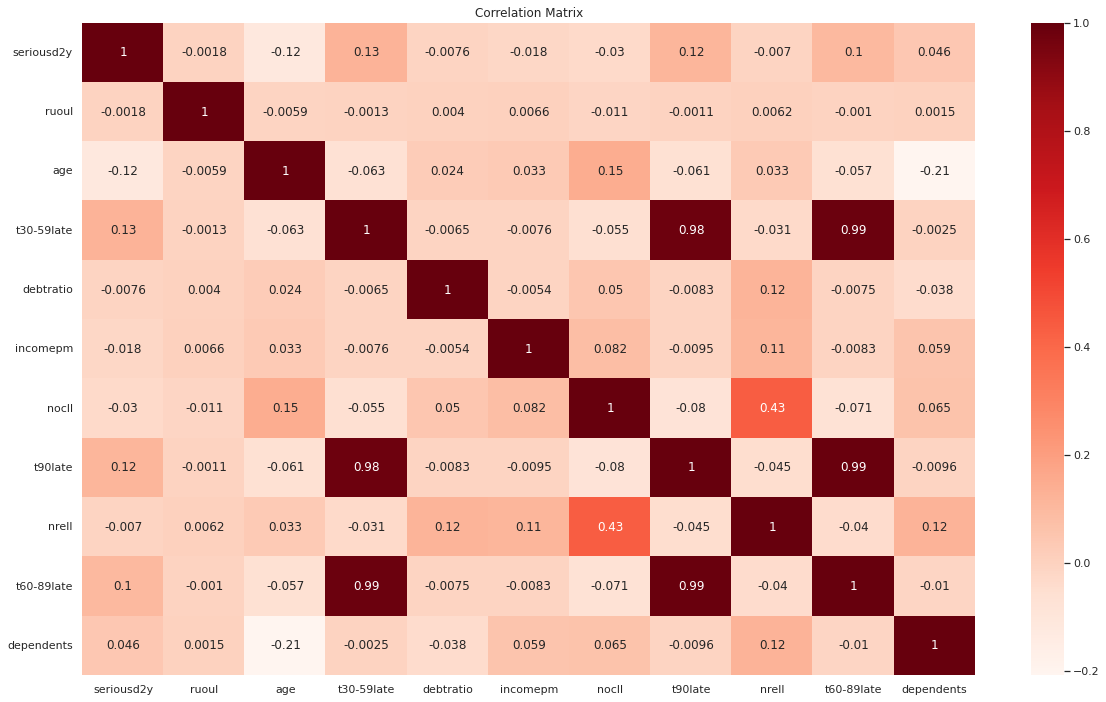

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,12)})

sns.heatmap(train_df.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix');

In [64]:
# dropping redundant labels
input_cols = input_cols.drop(['t30-59late', 't60-89late'])

## Splitting dataset into train and test parts

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[input_cols], train_df[target_cols], test_size=0.25, random_state=21)

## Model creation & training

Lets first define a function which prints the accuracy of models on training and validation data.

In [68]:
from sklearn.metrics import accuracy_score, confusion_matrix
def accu(modelx):
    print("Accuracy score (train):       {0:.3f} %".format(accuracy_score(y_train, modelx.predict(X_train))*100))
    print("Accuracy score (validation):  {0:.3f} %".format(accuracy_score(y_valid, modelx.predict(X_valid))*100))

### Using GradientBoostingClassifier

In [69]:
from sklearn.ensemble import GradientBoostingClassifier

In [70]:
# model with default parameters
gbc_model = GradientBoostingClassifier(random_state=21)

In [71]:
gbc_model.fit(X_train, y_train.seriousd2y)

GradientBoostingClassifier(random_state=21)

In [72]:
accu(gbc_model)

Accuracy score (train):       93.661 %
Accuracy score (validation):  93.613 %


Accuracy score of model on validation data is nearly same as score on training data.
Let's see if we can improve it by modifying some of the parameters.

In [74]:
#lets try by using different learning rates
for x in [0.5, 0.25, 0.05]:
    gbc_model1 = GradientBoostingClassifier(
        learning_rate=x,
        n_estimators=200,
        random_state=21,
    )
    gbc_model1.fit(X_train, y_train.seriousd2y)
    print(f"Learning rate : {x}")
    accu(gbc_model1)

Learning rate : 0.5
Accuracy score (train):       94.101 %
Accuracy score (validation):  93.429 %
Learning rate : 0.25
Accuracy score (train):       93.932 %
Accuracy score (validation):  93.533 %
Learning rate : 0.05
Accuracy score (train):       93.660 %
Accuracy score (validation):  93.603 %


The above results show improvement on accuracy score on train data, but it's not what we're aiming for. Accuracy score on validation data is more or less the same, so we will continue with learning rate of 0.1 (which is the default).

Now lets try the same approach for n_estimators.

In [ ]:
for x in range(250,851,100):
    gbc_model2 = GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=x,
        random_state=21,
    )
    gbc_model2.fit(X_train, y_train.seriousd2y)
    print(f"n_estimators : {x}")
    accu(gbc_model2)

n_estimators : 250
Accuracy score (train):       93.780 %
Accuracy score (validation):  93.624 %
n_estimators : 350
Accuracy score (train):       93.834 %
Accuracy score (validation):  93.608 %
n_estimators : 450
Accuracy score (train):       93.886 %
Accuracy score (validation):  93.571 %
n_estimators : 550
Accuracy score (train):       93.928 %
Accuracy score (validation):  93.581 %


From the above results, we see that changing n_estimators doesn't help in improving the accuracy.

Let's repeat the same steps for max_depth parameter.

In [ ]:
def max_depth_accu(md):
  gbc_model3 = GradientBoostingClassifier(max_depth=md,
                                      learning_rate=0.1,
                                      n_estimators=200,
                                      random_state=21,
                                      )
  gbc_model3.fit(X_train, y_train.seriousd2y)
  print(f"max_depth : {md}")
  accu(gbc_model3)

In [ ]:
for md in range(4, 11):
  max_depth_accu(md)

Changing the depths too doesn't seems to increase accuracy.


Hence the best GradientBoostingClassifier model will have the following parameters:
* n_estimators = 200,
* max_depth = 3 (default)
* learning_rate = 0.1 (default)

In [ ]:
best_gbc = GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=200,
        max_depth=3,
        random_state=21,
    )

### Using XGBClassifier

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# model with default parameters
xgc_model = XGBClassifier(
    random_state=21,
    n_jobs=-1,
    use_label_encoder=False,
)

In [ ]:
xgc_model.fit(X_train, y_train.seriousd2y)

In [ ]:
accu(xgc_model)

Accuracy of this model is nearly same as GradientBoostingClassifier. Let's see if we can improve this.

Testing with different learning rates.

In [ ]:
for x in [0.75,0.5,0.25,0.1,0.05]:
  xgc_model1 = XGBClassifier(
      learning_rate=x,
      n_jobs=-1,
      random_state=21,
      verbosity=0,
      use_label_encoder=False,
  )
  xgc_model1.fit(X_train, y_train.seriousd2y)
  print(f"Learning rate : {x}")
  accu(xgc_model1)

learning rate of 0.1 performs slightly better than the default one. We will be using this in further models.

Let's repeat the above steps for n_estimators parameter.

In [ ]:
for x in range(200,1001,100):
  xgc_model2 = XGBClassifier(
      learning_rate=0.1,
      n_estimators=x,
      n_jobs=-1,
      random_state=21,
      verbosity=0,
      use_label_encoder=False,
  )
  xgc_model2.fit(X_train, y_train.seriousd2y)
  print(f"n_estimators : {x}")
  accu(xgc_model2)

n_estimator with a value of 100 performs better than the above results. So we'll continue with 100 for n_estimators.

In [ ]:
best_xgc = XGBClassifier(
      learning_rate=0.1,
      n_jobs=-1,
      random_state=21,
      verbosity=0,
      use_label_encoder=False,
  )

## Testing model on original test data

Since accuracy of GradientBoostingClassifier is better (slightly) than XGBClassifier, we will use it for our predictions.

In [ ]:
model = best_gbc

In [ ]:
model.fit(X_train, y_train.SeriousDlqin2yrs)

In [ ]:
preds = model.predict_proba(test_df[input_cols])

In [ ]:
preds

In [ ]:
result_df = pd.DataFrame({
    'Id': np.arange(1, 101504),
    'Probability': preds[:,1]
})

In [ ]:
result_df.to_csv('submission.csv', index=False)

best_gbc model gives an accuracy of 0.82829 on the test data.
Let's check accuracy of best_xgc model.

In [ ]:
model2 = best_xgc

In [ ]:
model2.fit(X_train, y_train.seriousd2y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=21, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [ ]:
preds2 = model2.predict_proba(test_df[input_cols])

In [ ]:
preds2

array([[0.8484671 , 0.15153287],
       [0.76079106, 0.23920895],
       [0.99001646, 0.00998356],
       ...,
       [0.98858637, 0.01141361],
       [0.6849971 , 0.31500292],
       [0.76249325, 0.23750672]], dtype=float32)

In [ ]:
result_df2 = pd.DataFrame({
    'Id': np.arange(1, 101504),
    'Probability': preds2[:,1]
})

In [ ]:
result_df2.to_csv('submission2.csv', index=False)

Though accuracy of both the models on validation data was nearly same, the best_xgc model performs significantly better on the test data with an accuracy score of 0.84117.

In [ ]:
model.predict(test_df[input_cols])

array([0, 0, 0, ..., 0, 0, 0])

## Model visualization

In [ ]:
gbc_model = best_gbc.fit(X_train, y_train.seriousd2y)

In [ ]:
importances_df = pd.DataFrame({
    'feature':input_cols,
    'importance':gbc_model.feature_importances_
})
importances_df

,feature,importance
0,RevolvingUtilizationOfUnsecuredLines,0.050667
1,age,0.038386
2,NumberOfTime30-59DaysPastDueNotWorse,0.172796
3,DebtRatio,0.005792
4,MonthlyIncome,0.021052
5,NumberOfOpenCreditLinesAndLoans,0.016996
6,NumberOfTimes90DaysLate,0.562304
7,NumberRealEstateLoansOrLines,0.015938
8,NumberOfTime60-89DaysPastDueNotWorse,0.113618
9,NumberOfDependents,0.002451


In [ ]:
importances_df.to_csv('ans.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 20,20

plot_tree(best_xgc, rankdir='LR')
plt.show()

In [ ]:
importances_df = pd.DataFrame({
    'feature':input_cols,
    'importance':best_xgc.feature_importances_
})
importances_df

,feature,importance
0,RevolvingUtilizationOfUnsecuredLines,0.237682
1,age,0.039016
2,NumberOfTime30-59DaysPastDueNotWorse,0.149072
3,DebtRatio,0.021863
4,MonthlyIncome,0.021423
5,NumberOfOpenCreditLinesAndLoans,0.023624
6,NumberOfTimes90DaysLate,0.335130
7,NumberRealEstateLoansOrLines,0.039106
8,NumberOfTime60-89DaysPastDueNotWorse,0.124109
9,NumberOfDependents,0.008975


In [ ]:
importances_df.to_csv('ans.csv', index=False)